In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.datasets import fetch_openml
from scipy.signal import convolve2d
from copy import deepcopy
from sklearn.mixture import GaussianMixture as GMM
import cv2 as cv
import winsound as ws
import os


In [263]:
def train(n_samples, m, n):
    data = load_samples(mnist, n_samples=n_samples)
    train_data = extract_patch(data, m=m)
    gm = GMM(n_components = n, random_state = 0, warm_start=True, verbose=2).fit(train_data)
    return gm

def extract_patch(this, m=8):

    l, x, y = this.shape
    x = x - m + 1
    y = y - m + 1

    patches = np.zeros((l * x * y, m**2), dtype=np.float64)

    for n in range(l):
        for i in range(x):
            for j in range(y):
                patches[n * x * y + y * i + j, :] = this[n, i : i + m, j : j + m].reshape((m**2,))

    return patches


def load_images(path, idx=None):

    images = []

    if not os.path.isfile(f'./{path}'):
        files = [f'./{path}/{i}' for i in os.listdir(f'./{path}')]
    else : files = [path]

    for n, file in enumerate(files):
        if idx is None or n in idx:
            img = cv.imread(f'./{file}')
            img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
            images.append(img.astype(np.float64))

    return np.asarray(images)


def remake_image(patches, m, imgSize=28):

    n_patches = imgSize - m + 1
    a = np.eye(n_patches**2)
    a = a.reshape((n_patches**2, n_patches, n_patches))

    total   =   np.asarray([convolve2d(a[i, :, :], patches[i]) for i in range(n_patches**2)])
    total   =   np.sum(total, axis=0)
    weights =   np.asarray([convolve2d(a[i, :, :], np.ones((m,m))) for i in range(n_patches**2)])
    weights =   np.sum(weights, axis=0)

    return total / weights


def load_samples(mnist, n_samples):

    myset = []

    data = np.asarray(mnist.data)
    labels = mnist.target.astype("int64").to_numpy()

    data = data.reshape((data.shape[0], 28, 28))

    l = np.zeros(10)

    for i, label in enumerate(labels):
        if label == np.argmin(l) :
            l[label] = l[label] + 1
            myset.append(i)
            if len(myset) == n_samples :
                break
    print('samples of each label:\n',l)

    return data[myset, :, :]

def Z_Y(gm, y, W, s, m, n):

    ####without posterior:
    # a = np.asarray(gm.means_[gm.predict(y)])
    # return a.T
    l = len(y)
    prec_Z = np.asarray(gm.precisions_)
    cov_Z = np.asarray(gm.covariances_)
    mu_Z = np.asarray(gm.means_)
    pi_Z = np.asarray(gm.weights_)

    prec_Y = np.eye(m**2) / s**2

    prec_ZY = prec_Z + W.T @ prec_Y @ W
    cov_ZY = np.linalg.inv(prec_ZY)

    cov_ZY_appx = cov_ZY - np.eye(m**2) * np.min(cov_ZY)

    mu_ZY = cov_ZY @ (np.tile((W.T @ prec_Y @ y.T), (n, 1, 1)) + np.tile(prec_Z @ mu_Z[:, :, np.newaxis], (1, 1, l))) # 

    diff_to_mus = np.tile(y.T, (n,1,1)) - mu_ZY
    ML = np.argmin(np.linalg.norm(diff_to_mus, axis=1), axis=0)


    logDist = np.transpose(diff_to_mus, [0, 2, 1]) @ diff_to_mus / 2
    logDist = np.asarray([np.diag(i) for i in logDist])

    MAP = np.argmax(np.log(pi_Z) - np.log(np.linalg.det(cov_ZY_appx)) / 2 - logDist.T, axis=1)


    ans = np.zeros((m**2, l), dtype=np.float64)

    for i in range(l):
        ans[:, i] = mu_ZY[MAP[i], :, i]

        
    return ans

def beep():
    for i in range(6):
        ws.Beep(1000, 300)
        ws.Beep(2000, 300)


In [79]:
mnist = fetch_openml('mnist_784')


c:\Users\AmirH\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [80]:
n_samples = 100
ms      = [4, 8, 12, 16, 20, 28]
n = 20
gm_by_m = []

for i, m in enumerate(ms):

    gm = train(n_samples, m, n)
    gm_by_m.append(gm)



samples of each label:
 [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
Initialization 0
  Iteration 10	 time lapse 5.75738s	 ll change 3.58516
  Iteration 20	 time lapse 5.45920s	 ll change 0.01687
  Iteration 30	 time lapse 5.42900s	 ll change 0.01103
Initialization converged: True	 time lapse 21.03225s	 ll 34.12558
samples of each label:
 [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
Initialization 0
  Iteration 10	 time lapse 12.40710s	 ll change 2.11959
  Iteration 20	 time lapse 11.61743s	 ll change 0.63962
  Iteration 30	 time lapse 11.47765s	 ll change 0.22166
Initialization converged: True	 time lapse 44.76486s	 ll -44.31428
samples of each label:
 [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
Initialization 0
  Iteration 10	 time lapse 19.95026s	 ll change 4.28750
  Iteration 20	 time lapse 19.42260s	 ll change 0.24767
  Iteration 30	 time lapse 19.33542s	 ll change 0.03722
Initialization converged: True	 time lapse 64.51283s	 ll -340.19730
samples of each label:
 [10. 10. 10. 10. 10. 10. 

c:\Users\AmirH\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\linalg\linalg.py:2146: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


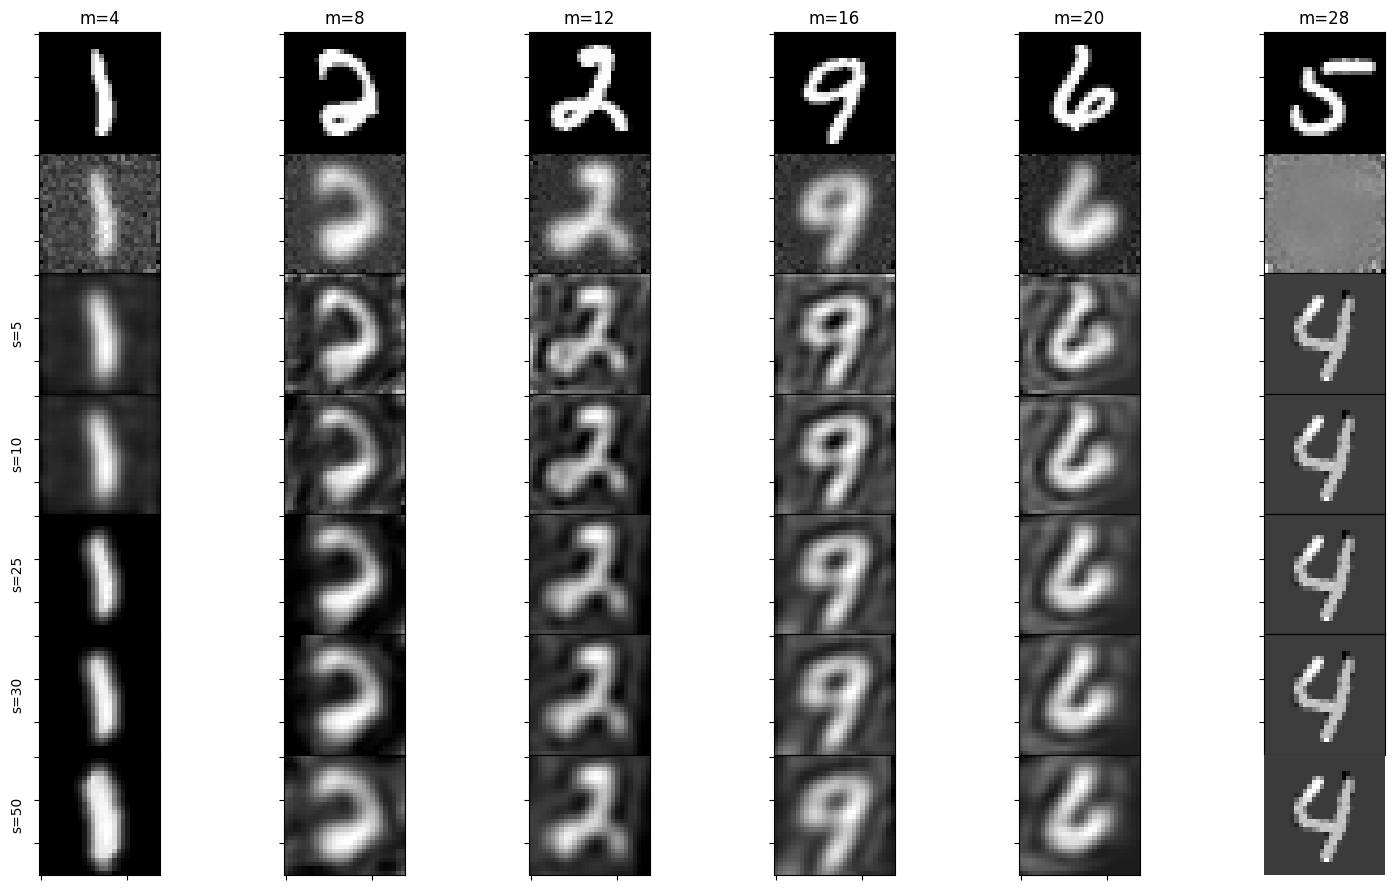

In [264]:
n_samples = 100
ms      = [4, 8, 12, 16, 20, 28]
sigs    = [5, 10, 25, 30, 50]
n_images = len(ms)
n = 20

fig, axes = plt.subplots(7, n_images, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(15,9))

for i, m in enumerate(ms):

    gm = gm_by_m[i]

    all_images = load_images(f'./Dataset/MNIST-m={m}/MNIST/corrupted/')
    all_originals = load_images(f'./Dataset/MNIST-m={m}/MNIST/original/')
    W = np.load(f'Dataset/MNIST-m={m}/MNIST/W.npy')

    idx = np.random.randint(0, len(all_images))
    image       =   all_images[idx, :, :]
    original    =   all_originals[idx, :, :]
    original /= np.max(original)

    axes[0, i].set_title(f'm={m}')
    axes[0, i].imshow(original, cmap='gray')
    axes[1, i].imshow(image, cmap='gray')

    test_data = extract_patch(image.reshape((1, 28, 28)), m=m)

    for k, sig in enumerate(sigs):

        try:
            mapResult   =  [res.reshape((m,m)) for res in Z_Y(gm, test_data, W, sig, m, n).T]
        except Exception:
            mapResult   =  [np.ones((m,m)) for i in range(len(test_data))]

        remaked_map = remake_image(mapResult, m)
        remaked_map = remaked_map / np.max(remaked_map)
        axes[2 + k, i].imshow(remaked_map, cmap='gray')

        if i == 0:
            axes[2 + k, i].set_ylabel(f's={sig}')


for i in axes.flatten():
    i.set_xticklabels([])
    i.set_yticklabels([])

fig.tight_layout()
plt.grid(False)
plt.axis('off')
plt.show()

In [183]:
n_samples = 200
n = 20

ms = [4, 8]
gm_by_m_accurate = []

for i, m in enumerate(ms):
    gm_by_m_accurate.append(train(n_samples, m, n))


samples of each label:
 [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
Initialization 0
  Iteration 10	 time lapse 12.59845s	 ll change 2.48819
  Iteration 20	 time lapse 10.73773s	 ll change 0.09595
Initialization converged: True	 time lapse 33.95846s	 ll 34.14151
samples of each label:
 [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
Initialization 0
  Iteration 10	 time lapse 25.16808s	 ll change 4.23250
  Iteration 20	 time lapse 24.55345s	 ll change 0.16429
  Iteration 30	 time lapse 23.24820s	 ll change 0.14390
  Iteration 40	 time lapse 23.67685s	 ll change 0.27377
Initialization converged: True	 time lapse 117.81403s	 ll -42.97282


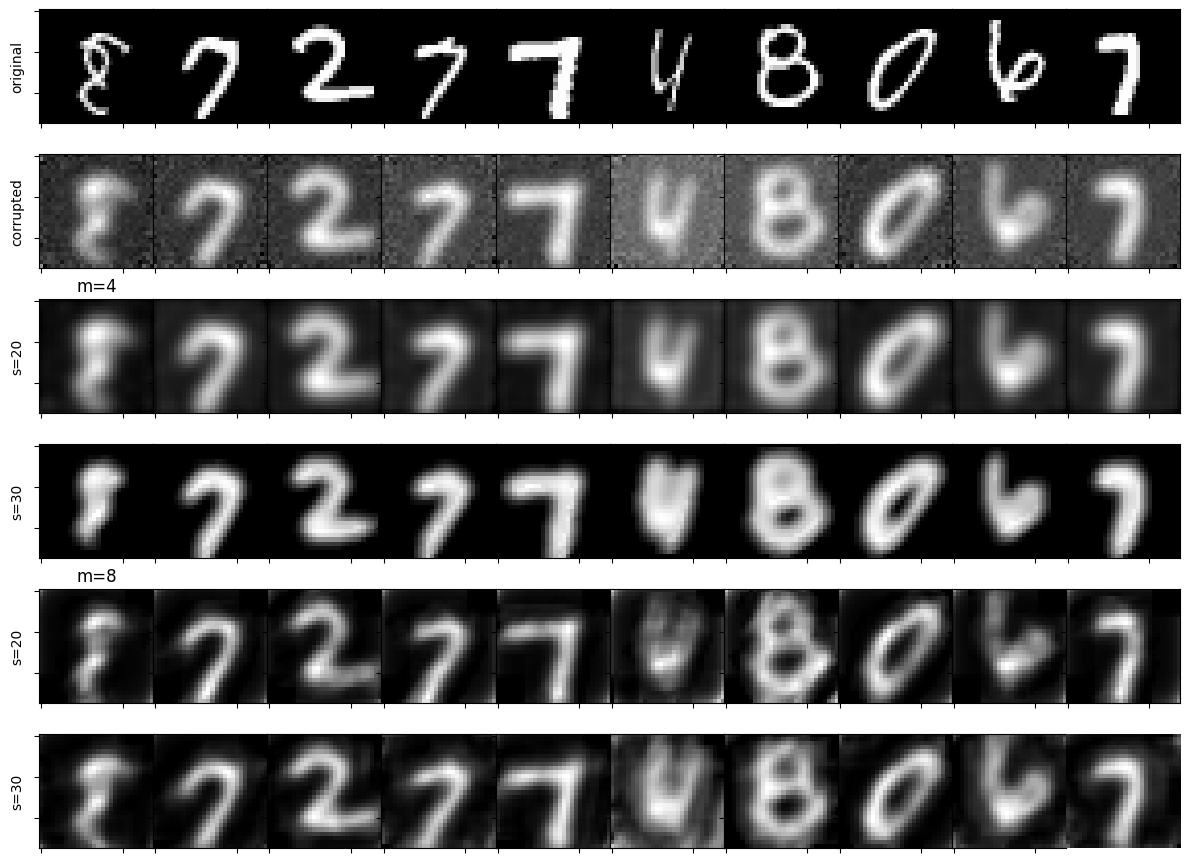

In [265]:
n_images = 10
n_samples = 200
n = 20

distance = np.zeros((2, n_images))
fig, axes = plt.subplots(6, n_images, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(12,9))
idx = np.random.randint(0, len(all_images), (n_images,))

axes[0,0].set_ylabel('original')
axes[1,0].set_ylabel('corrupted')

ms = [4, 8]
sigs = [20, 30]

all_images = load_images(f'./Dataset/MNIST-m={12}/MNIST/corrupted/')
all_originals = load_images(f'./Dataset/MNIST-m={12}/MNIST/original/')


for i, m in enumerate(ms):

    gm = gm_by_m_accurate[i]
    W = np.load(f'Dataset/MNIST-m={m}/MNIST/W.npy')

    axes[(i + 1) * 2, 0].set_title(f'm={m}')

    for x, id in enumerate(idx):
        image       =   all_images[id, :, :]
        original    =   all_originals[id, :, :]
        original   /=   np.max(original)

        if i == 0:
            axes[0, x].imshow(original, cmap='gray')
            axes[1, x].imshow(image, cmap='gray')

        test_data = extract_patch(image.reshape((1, 28, 28)), m=m)

        for k, sig in enumerate(sigs):


            mapResult   =  [res.reshape((m,m)) for res in Z_Y(gm, test_data, W, sig, m, n).T]
            remaked_map = remake_image(mapResult, m)
            remaked_map = remaked_map / np.max(remaked_map)
            axes[2 * (i + 1) + k, x].imshow(remaked_map, cmap='gray')

            if x == 0:
                axes[2 * (i + 1) + k, 0].set_ylabel(f's={sig}')


for i in axes.flatten():
    i.set_xticklabels([])
    i.set_yticklabels([])

fig.tight_layout()
plt.grid(False)
plt.axis('off')
plt.show()

In [130]:
n_samples = 200
m = 4

gm_by_n = []

for i, n in enumerate([10,20,30,40,50,60,70,80]):

    gm = train(n_samples, m, n)
    gm_by_n.append(gm)



samples of each label:
 [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
Initialization 0
  Iteration 10	 time lapse 5.57037s	 ll change 0.79203
  Iteration 20	 time lapse 5.08074s	 ll change 0.00064
Initialization converged: True	 time lapse 10.65210s	 ll 26.04743
samples of each label:
 [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
Initialization 0
  Iteration 10	 time lapse 12.33084s	 ll change 2.48819
  Iteration 20	 time lapse 10.54017s	 ll change 0.09595
Initialization converged: True	 time lapse 32.47730s	 ll 34.14151
samples of each label:
 [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
Initialization 0
  Iteration 10	 time lapse 17.25577s	 ll change 1.86421
  Iteration 20	 time lapse 16.25205s	 ll change 0.03566
  Iteration 30	 time lapse 16.12151s	 ll change 0.00402
  Iteration 40	 time lapse 16.17457s	 ll change 0.00362
  Iteration 50	 time lapse 16.39018s	 ll change 0.00402
Initialization converged: True	 time lapse 93.44415s	 ll 36.51867
samples of each label:
 [20. 20. 20. 20. 20. 20. 20

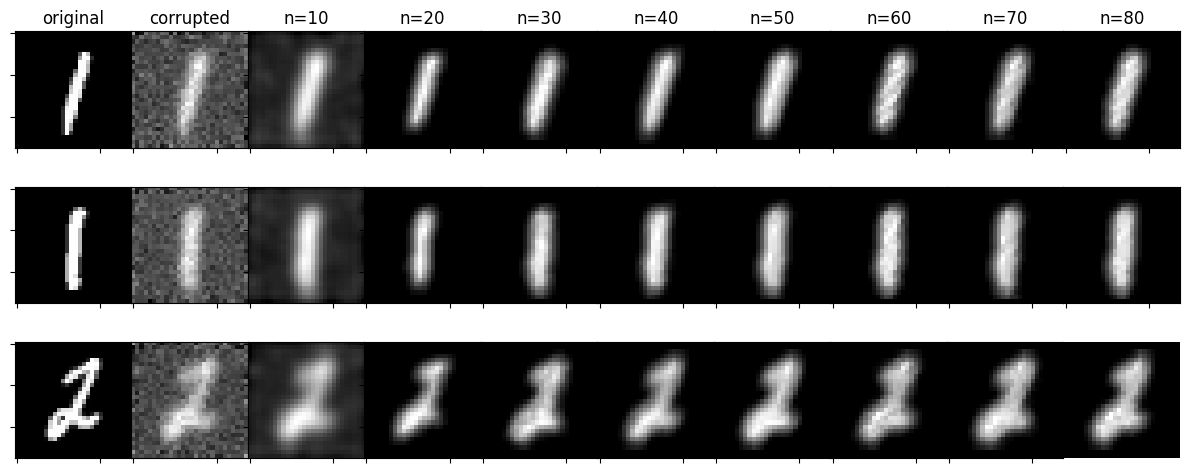

In [266]:
n_samples = 200
n_images = 3
m = 4

W = np.load(f'Dataset/MNIST-m={m}/MNIST/W.npy')
all_images = load_images(f'./Dataset/MNIST-m={m}/MNIST/corrupted/')
all_originals = load_images(f'./Dataset/MNIST-m={m}/MNIST/original/')

fig, axes = plt.subplots(n_images, 10, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(12,5))
idx = np.random.randint(0, len(all_images), (n_images,))

axes[0,0].set_title('original')
axes[0,1].set_title('corrupted')


for i, n in enumerate([10,20,30,40,50,60,70,80]):

    axes[0,i + 2].set_title(f'n={n}')

    gm = gm_by_n[i]

    for j, id in enumerate(idx):
        image       =   all_images[id, :, :]
        original    =   all_originals[id, :, :]
        original   /=   np.max(original)

        if i == 0:
            axes[j, 0].imshow(original, cmap='gray')
            axes[j, 1].imshow(image, cmap='gray')

        test_data = extract_patch(image.reshape((1, 28, 28)), m=m)

        mapResult   =  [res.reshape((m,m)) for res in Z_Y(gm, test_data, W, 23, m, n).T]

        remaked_map = remake_image(mapResult, m)
        remaked_map = remaked_map / np.max(remaked_map)
        axes[j, i + 2].imshow(remaked_map, cmap='gray')

for i in axes.flatten():
    i.set_xticklabels([])
    i.set_yticklabels([])

fig.tight_layout()
plt.grid(False)
plt.axis('off')
plt.show()

In [184]:
n_samples = 1000
n = 25

finalgm4 = train(n_samples, 4, n)
finalgm8 = train(n_samples, 8, n)

beep()

samples of each label:
 [100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
Initialization 0
  Iteration 10	 time lapse 73.99104s	 ll change 0.48240
  Iteration 20	 time lapse 68.16612s	 ll change 0.00586
  Iteration 30	 time lapse 65.91863s	 ll change 0.00083
Initialization converged: True	 time lapse 208.07580s	 ll 35.43151
samples of each label:
 [100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
Initialization 0
  Iteration 10	 time lapse 153.96963s	 ll change 3.90091
  Iteration 20	 time lapse 139.87661s	 ll change 0.10669
  Iteration 30	 time lapse 142.86489s	 ll change 0.08214
  Iteration 40	 time lapse 142.02535s	 ll change 0.09889
  Iteration 50	 time lapse 140.94485s	 ll change 0.15338
Initialization converged: True	 time lapse 804.55991s	 ll -36.62997


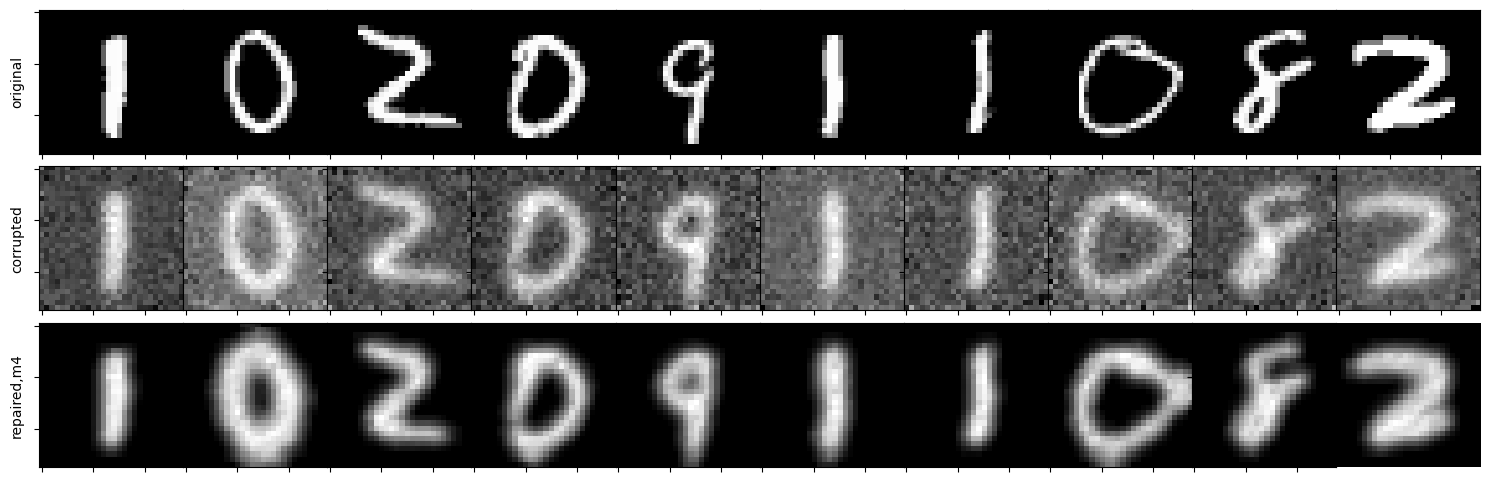

In [276]:
W4 = np.load(f'Dataset/MNIST-m={4}/MNIST/W.npy')
all_images = load_images(f'./Dataset/MNIST-m={4}/MNIST/corrupted/')
all_originals = load_images(f'./Dataset/MNIST-m={4}/MNIST/original/')

n_images = 10
fig, axes = plt.subplots(3, n_images, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(15,5))
idx = np.random.randint(0, len(all_images), (n_images,))

for j, id in enumerate(idx):
        image       =   all_images[id, :, :]
        original    =   all_originals[id, :, :]
        original   /=   np.max(original)

        axes[0, j].imshow(original, cmap='gray')
        axes[1, j].imshow(image, cmap='gray')

        test_data4 = extract_patch(image.reshape((1, 28, 28)), m=4)

        mapResult4   =  [res.reshape((4,4)) for res in Z_Y(finalgm4, test_data4, W4, 25, 4, 25).T]

        remaked_map4 = remake_image(mapResult4, 4)

        axes[2, j].imshow(remaked_map4, cmap='gray')

axes[0,0].set_ylabel('original')
axes[1,0].set_ylabel('corrupted')
axes[2,0].set_ylabel('repaired,m4')

for i in axes.flatten():
    i.set_xticklabels([])
    i.set_yticklabels([])

fig.tight_layout()
plt.grid(False)
plt.axis('off')
plt.show()